In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm import tqdm
import zipfile
import rasterio
from rasterio.windows import Window
from torch.utils.data import Dataset
import gc
import sys

In [2]:
size = 512
reduce = 2
MASKS = '../data/train.csv'
DATA = '../data/raw/'
OUT_TRAIN = '../data/processed/train2.zip'
OUT_MASKS = '../data/processed/masks2.zip'

In [3]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1, n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan); continue
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs            

In [4]:
df_masks = pd.read_csv(MASKS, index_col='id')
df_masks = df_masks[df_masks.index.isin(['2f6ecfcdf', '0486052bb', '8242609fa', 'aaa6a05cc', 'b2dc8411c'])]

In [6]:
sth = 40
pth = 1000*(size//256)**2

class Dataset(Dataset):
    def __init__(self, idx, size=size, reduce=reduce, encs=None):
        self.data = rasterio.open(os.path.join(DATA, f'{idx}.tiff'))
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                self.layers.extend(rasterio.open(subdataset) for subdataset in subdatasets)
        self.shape = self.data.shape
        self.reduce = reduce
        self.size = reduce * size
        self.pad0 = (self.size - self.shape[0]%self.size)%self.size
        self.pad1 = (self.size - self.shape[1]%self.size)%self.size
        self.n0max = (self.shape[0] + self.pad0)//self.size
        self.n1max = (self.shape[1] + self.pad1)//self.size
        self.mask = enc2mask(encs, (self.shape[1], self.shape[0])) if encs is not None else None

    def __len__(self):
        return self.n0max*self.n1max

    def __getitem__(self, idx):
        n0, n1 = idx//self.n1max, idx%self.n1max
        x0, y0 = -self.pad0//2 + n0*self.size, -self.pad1//2 + n1*self.size
        p00, p01 = max(0, x0), min(x0 + self.size, self.shape[0])
        p10, p11 = max(0, y0), min(y0 + self.size, self.shape[1])
        img = np.zeros((self.size, self.size, 3), dtype=np.uint8)
        mask = np.zeros((self.size, self.size), dtype=np.uint8)
        if self.data.count == 3:
            img[(p00-x0):(p01-x0), (p10-y0):(p11-y0)] = np.moveaxis(
                self.data.read([1, 2, 3], window=Window.from_slices((p00, p01), (p10, p11))), 0, -1)
        else:
            for i, layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0), (p10-y0):(p11-y0), i] = layer.read(1, window=Window.from_slices((p00, p01), (p10, p11)))
        if self.mask is not None:
            mask[(p00-x0):(p01-x0), (p10-y0):(p11-y0)] = self.mask[p00:p01, p10:p11]

        if self.reduce != 1:
            img = cv2.resize(img, (self.size//self.reduce, self.size//self.reduce), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (self.size//self.reduce, self.size//self.reduce), interpolation=cv2.INTER_NEAREST)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        return img, mask, (-1 if (s>sth).sum() <= pth or img.sum() <= pth else idx)

In [7]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #image+mask dataset
        ds = Dataset(index,encs=encs)
        for i in range(len(ds)):
            im,m,idx = ds[i]
            if idx < 0: continue
                
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            #write data   
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{idx:04d}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{idx:04d}.png', m)
        
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\broug\mambaforge\envs\torch\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 5/5 [05:48<00:00, 69.60s/it] 

mean: [0.67251248 0.53909105 0.74221201] , std: [0.15923204 0.21816407 0.11615807]


In [13]:
sorted(img_arch.namelist())

['0486052bb_0079.png',
 '0486052bb_0080.png',
 '0486052bb_0081.png',
 '0486052bb_0082.png',
 '0486052bb_0083.png',
 '0486052bb_0084.png',
 '0486052bb_0085.png',
 '0486052bb_0086.png',
 '0486052bb_0087.png',
 '0486052bb_0088.png',
 '0486052bb_0089.png',
 '0486052bb_0090.png',
 '0486052bb_0091.png',
 '0486052bb_0092.png',
 '0486052bb_0093.png',
 '0486052bb_0094.png',
 '0486052bb_0095.png',
 '0486052bb_0096.png',
 '0486052bb_0097.png',
 '0486052bb_0098.png',
 '0486052bb_0099.png',
 '0486052bb_0100.png',
 '0486052bb_0114.png',
 '0486052bb_0115.png',
 '0486052bb_0116.png',
 '0486052bb_0117.png',
 '0486052bb_0118.png',
 '0486052bb_0119.png',
 '0486052bb_0120.png',
 '0486052bb_0121.png',
 '0486052bb_0122.png',
 '0486052bb_0123.png',
 '0486052bb_0124.png',
 '0486052bb_0125.png',
 '0486052bb_0126.png',
 '0486052bb_0127.png',
 '0486052bb_0128.png',
 '0486052bb_0129.png',
 '0486052bb_0130.png',
 '0486052bb_0131.png',
 '0486052bb_0132.png',
 '0486052bb_0133.png',
 '0486052bb_0134.png',
 '0486052bb

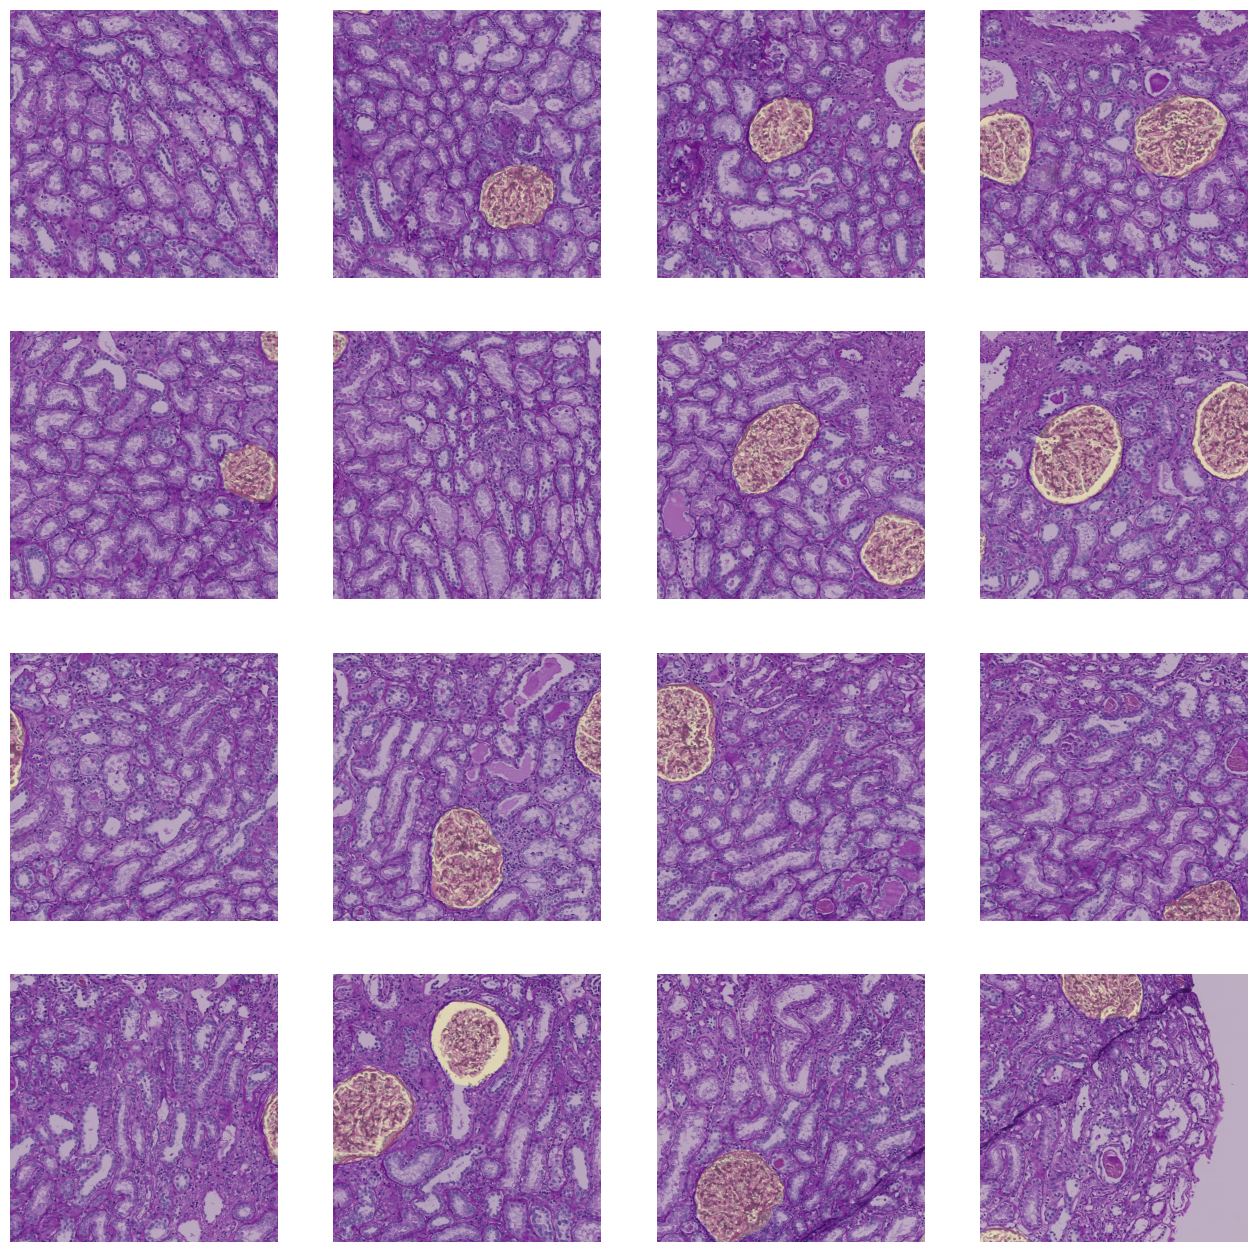

In [8]:
import itertools

columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()